# Predicting Human Activity Using Smartphone Data

I want to be able to predict how people are moving based on data collection from their smart phones. 

I will be using data from the Human Activity Recognition database which was made from the study of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, 3-axial linear acceleration and 3-axial angular velocity were captured at a constant rate of 50Hz. The experiments were also video-recorded and the outcome was labeled manually. 

The dataset has already been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.

In [1]:
import pandas as pd
import numpy as np
import scipy
import random
import matplotlib.pyplot as plt
import time
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.utils import resample
from sklearn.naive_bayes import BernoulliNB
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import sklearn
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from matplotlib.cm import get_cmap
from matplotlib.colors import rgb2hex

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Importing the Data

I must first make sure my data is clean and ready to be worked with. I will import, inspect, and clean my data.

In [2]:
train = pd.read_csv('C:\\Code\\Data\\human-activity-recognition-with-smartphones\\train.csv')
test = pd.read_csv('C:\\Code\\Data\\human-activity-recognition-with-smartphones\\test.csv')

In [3]:
print('Are there any null values in the training set?')
print(train.isnull().values.any())
print('\nAre there any null values in the testing set?')
print(test.isnull().values.any())

Are there any null values in the training set?
False

Are there any null values in the testing set?
False


In [4]:
train['Data'] = 'Train'
test['Data'] = 'Test'
both = pd.concat([train, test], axis=0).reset_index(drop=True)
both['subject_str'] = '#' + both['subject'].astype(str)

train = train.drop('Data',1)
test = test.drop('Data',1)

both_df = both.drop(['Activity','subject'],1)

In [5]:
both_df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Data,subject_str
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,Train,#1
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,Train,#1
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,Train,#1
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,Train,#1
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,Train,#1


In [6]:
print('Training Set')
print('\nShape:')
print(train.shape)
print('\nFirst 5 Rows of the Training Set:')
display(train.head())

Training Set

Shape:
(7352, 563)

First 5 Rows of the Training Set:


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [7]:
print('Testing Set')
print('\nShape:')
print(test.shape)
print('\nFirst 5 Rows of the Testing Set:')
display(test.head())

Testing Set

Shape:
(2947, 563)

First 5 Rows of the Testing Set:


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2,STANDING


Both data sets have 563 features, with only one of them being the outcome feature, "Activity", which is the manual label put to each activity. Also, as discussed earlier, the training and test set do indeed have a 70/30 split. 

I will now initiated my data tests for furuther manipulation. Along with the outcome variable Activity, I will also drop the subject number column from my data. As I am trying to predict actions done by any human, it should by irrelevent who did them.

In [8]:
#initiate train and testing features and outcomes
Xtrain = train.drop(['Activity','subject'],1)
Ytrain = train.Activity

Xtest = test.drop(['Activity','subject'],1)
Ytest = test.Activity

## Research questions:

1. Are there any errorneous values in the data set such as blanks or erroneous characters
2. Are the column labels unique? Are the labels of the training and test set identical?
3. Is the training data set balanced?
4. Are there any duplicate columns in the training and testing data?

### Erroneous Values


Since all of the data should be numbers between -1 and 1, with the exception of the outcome variable, I can check for erroneous data values by making sure all of my non-outcome features are a numeric variable type, or can be converted to one

In [9]:
display(Xtrain.describe())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


In [10]:
# show the count values of the describe function of Xtrain
print('Training Counts:')
display(Xtrain.describe().loc['count',:].value_counts())

# show the count values of the describe function of Xtrain
print('Testing Counts:')
display(Xtrain.describe().loc['count',:].value_counts())

Training Counts:


7352.0    561
Name: count, dtype: int64

Testing Counts:


7352.0    561
Name: count, dtype: int64

In [11]:
print('Summary of Training Variable Data Types\n')
print(Xtrain.dtypes.value_counts())
print('\nSummary of Testing Variable Data Types\n')
print(Xtest.dtypes.value_counts())

Summary of Training Variable Data Types

float64    561
dtype: int64

Summary of Testing Variable Data Types

float64    561
dtype: int64


All my variables have the same count (the number of rows in their respective data frame) when calling the describe function.  Additionally, each feature variable is the float type, meaning every variable must be a numberic values. Thus, I can conlcude that I do not have any variables or datapoints of erroneous type.

### Duplicate Column Names

Now I will see if I have a columns that share the same label, and correct them. 

In [12]:
print('Original Number of Training Features:')
print(Xtrain.shape[1])
print('\nOriginal Number of Testing Features:')
print(Xtest.shape[1])
#look at the columns names in training set
Xsettrain = set(Xtrain.columns)
print('\nNumber of Non-duplicate Name Training Features:')
print(len(Xsettrain))
#look at the columns names in testing set
Xsettest = set(Xtest.columns)
print('\nNumber of Non-duplicate Name Testing Features:')
print(len(Xsettest))
print('\nSet of difference in the training and testing sets:')
print(Xsettrain.symmetric_difference(Xsettest))

Original Number of Training Features:
561

Original Number of Testing Features:
561

Number of Non-duplicate Name Training Features:
561

Number of Non-duplicate Name Testing Features:
561

Set of difference in the training and testing sets:
set()


Both the training an the testing set have the same number of features and all their feature names are unique.

### Balanced Outcome

From here, I must make sure that my outcome is balanced, which can lead to serious problems when modeling if untrue.

In [13]:
# look at the outcome categories for training
print('Relative Fraction of the Outcome Training Variable')
print(round(train.Activity.value_counts()/train.shape[0],4))

Relative Fraction of the Outcome Training Variable
LAYING                0.1914
STANDING              0.1869
SITTING               0.1749
WALKING               0.1668
WALKING_UPSTAIRS      0.1459
WALKING_DOWNSTAIRS    0.1341
Name: Activity, dtype: float64


In [14]:
# look at the outcome categories for testing
print('Relative Fraction of the Outcome Testing Variable')
print(round(test.Activity.value_counts()/test.shape[0],4))

Relative Fraction of the Outcome Testing Variable
LAYING                0.1822
STANDING              0.1805
WALKING               0.1683
SITTING               0.1666
WALKING_UPSTAIRS      0.1598
WALKING_DOWNSTAIRS    0.1425
Name: Activity, dtype: float64


In [15]:
label = train.Activity
# Plotting data
label_counts = label.value_counts()

# Get colors
n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Create plot
data = go.Bar(x = label_counts.index,
              y = label_counts,
              marker = dict(color = colors))

layout = go.Layout(title = 'Smartphone Activity Label Distribution Amoung The Training Set',
                   xaxis = dict(title = 'Activity'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

In [16]:
label = test.Activity
# Plotting data
label_counts = label.value_counts()

# Get colors
n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Create plot
data = go.Bar(x = label_counts.index,
              y = label_counts,
              marker = dict(color = colors))

layout = go.Layout(title = 'Smartphone Activity Label Distribution Amoung The Testing Set',
                   xaxis = dict(title = 'Activity'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

There are 6 outcome activities: Laying, Sitting, Standing, Walking, Walking_Downstairs, and Walking_Upstairs. These Activities can be broadly put into 2 different categories, passive activities (laying, sitting, and standing) and active activities (walking, walking_upstairs, and walking_downstairs)

The outcome class is fairly balanced in the training, which will be very good for my model. It is also balanced in the testing set, but that is not nearly as important.

Now that I know the data is workable, I can begin doing more advanced manipulation. I know that my data set has a very large amount of features, which will make modleing computationally inefficient and prone to overfitting. My primary goal now is to remove extraneous features from my data.

# Data Exploration

In [17]:
both_tab = pd.crosstab(both.subject, both.Activity)

display(both_tab)

Activity,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
subject,,,,,,
1,50,47,53,95,49,53
2,48,46,54,59,47,48
3,62,52,61,58,49,59
4,54,50,56,60,45,52
5,52,44,56,56,47,47
6,57,55,57,57,48,51
7,52,48,53,57,47,51
8,54,46,54,48,38,41
9,50,50,45,52,42,49


In [18]:
# this creates a similar graph to the previous one, but with only a single subject, in this case 15

#sub15 = train.loc[train['subject']==15]
#fig = plt.figure(figsize=(40,10))
#ax1 = fig.add_subplot(131)
#ax1 = sns.stripplot(x='Activity', y=sub15.iloc[:,0], data=sub15, jitter=True)
#ax2 = fig.add_subplot(132)
#ax2 = sns.stripplot(x='Activity', y=sub15.iloc[:,1], data=sub15, jitter=True)
#ax3 = fig.add_subplot(133)
#ax3 = sns.stripplot(x='Activity', y=sub15.iloc[:,2], data=sub15, jitter=True)
#plt.suptitle('Mean tBody Acceleration for Subject 15')
#plt.show()

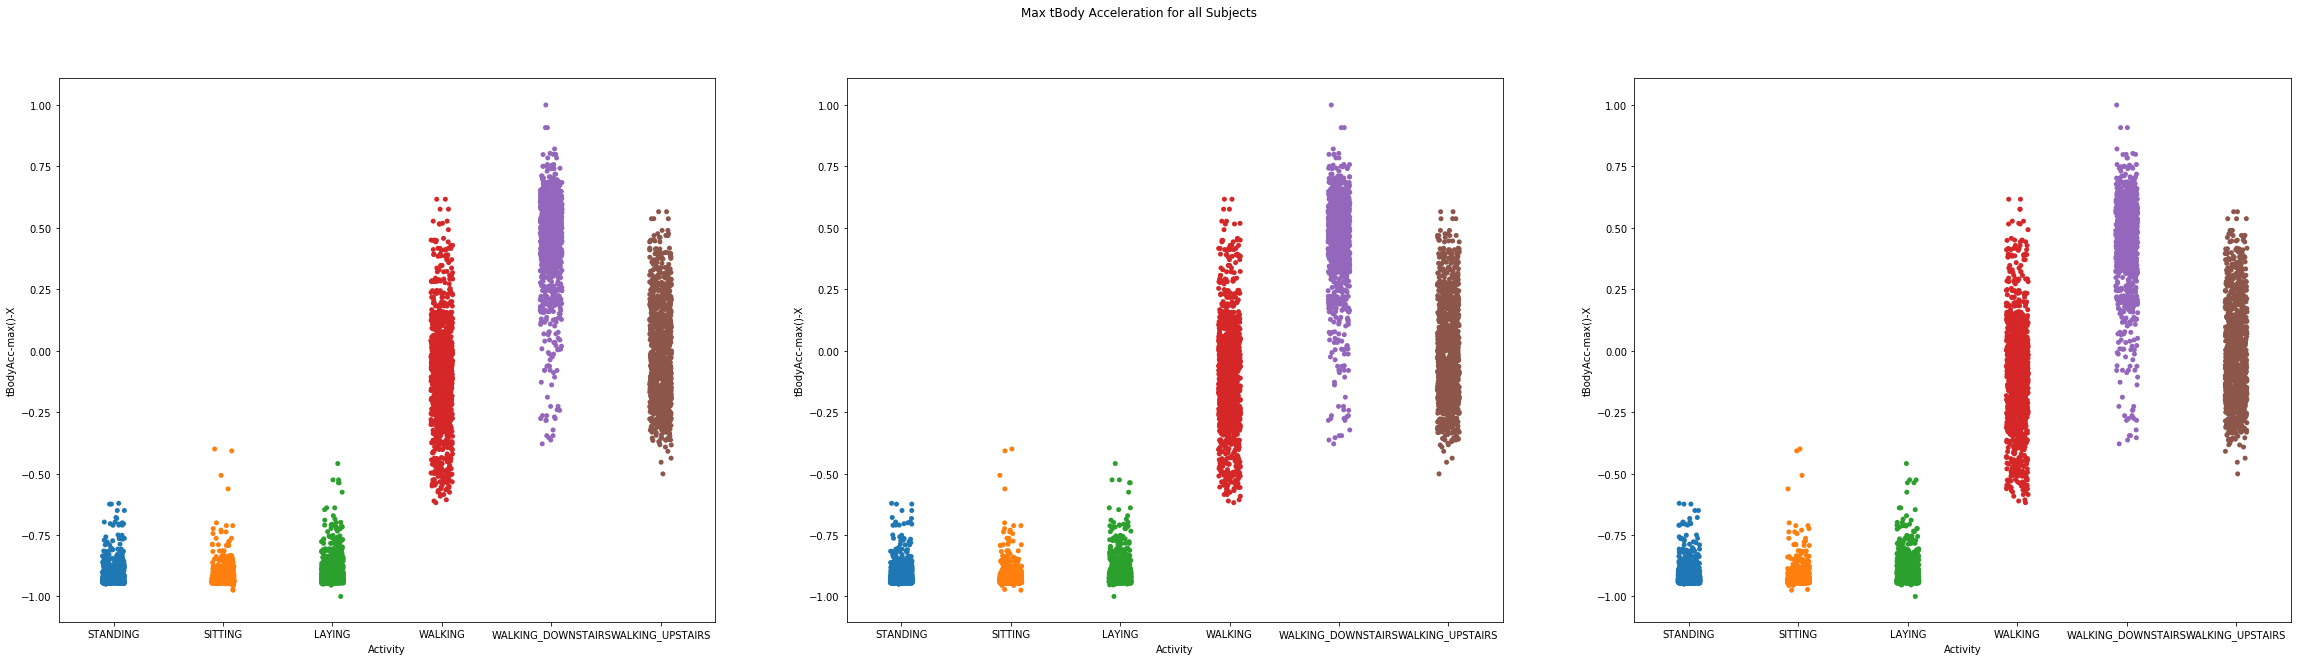

In [19]:
fig = plt.figure(figsize=(40,10))
ax1 = fig.add_subplot(131)
ax1 = sns.stripplot(x='Activity', y='tBodyAcc-max()-X', data=train, jitter=True)
ax2 = fig.add_subplot(132)
ax2 = sns.stripplot(x='Activity', y='tBodyAcc-max()-X', data=train, jitter=True)
ax3 = fig.add_subplot(133)
ax3 = sns.stripplot(x='Activity', y='tBodyAcc-max()-X', data=train, jitter=True)
plt.suptitle('Max tBody Acceleration for all Subjects')
plt.show()

The passive activities has much lower maximum acceleration values than the active activities maximum acceleration.

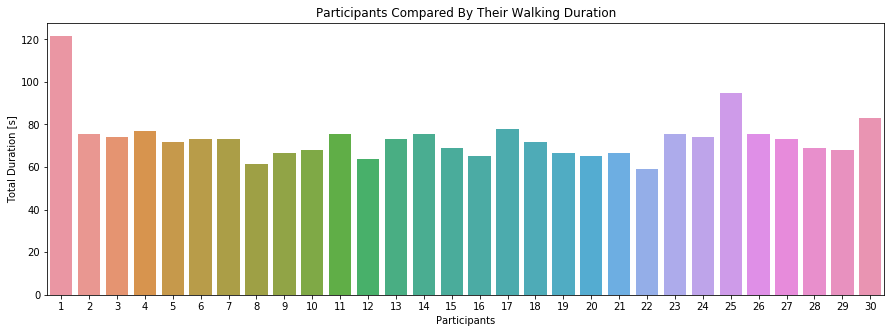

In [20]:
label = both.Activity
# Group the data by participant and compute total duration of walking
mask = label=='WALKING'
duration_df = (both[mask].groupby('subject')['Data'].count() * 1.28)

# Create plot
plot_data = duration_df.reset_index().sort_values('Data', ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Data')
plt.title('Participants Compared By Their Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

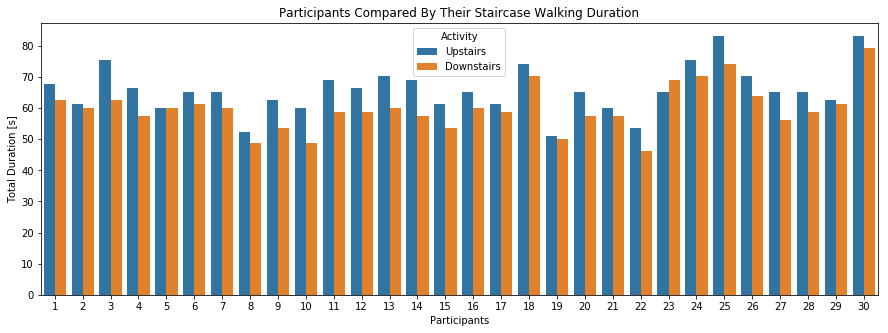

In [21]:
# Group the data by participant and compute total duration of staircase walking
mask = label.isin(['WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])
duration = (both[mask].groupby([label[mask], 'subject'])['Data'].count() * 1.28)

# Create plot
plot_data = duration.reset_index().sort_values('Data', ascending=False)
plot_data['Activity'] = plot_data['Activity'].map({'WALKING_UPSTAIRS':'Upstairs', 'WALKING_DOWNSTAIRS':'Downstairs'})

plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Data', hue='Activity')
plt.title('Participants Compared By Their Staircase Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

# Feature Improvement

While my data is ready for testing, there is still more that can be done. I will drastically improve the efficiency of my model by improving the feature selection.

Before I begin, I will determine the relative importance of the features, using the Random Forest model. If I need to choose between features, I can use the calculated feature importance to choose which one to keep. 

In [22]:
importances = pd.DataFrame()

In [23]:
rfc = ensemble.RandomForestClassifier()

rfc.fit(Xtrain,Ytrain)

Ypredrfc = rfc.predict(Xtest)

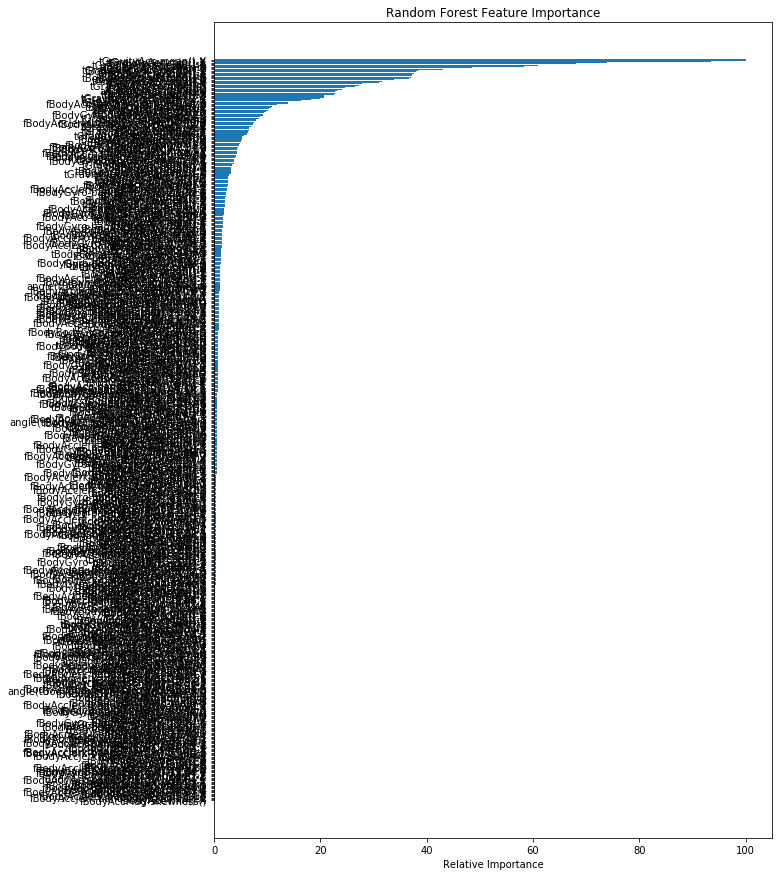

In [24]:
feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,15))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, Xtrain.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest Feature Importance')
plt.show()

importances['Names'] = list(Xtrain.columns[sorted_idx])
importances['Imp'] = list(feature_importance[sorted_idx])

## Remove Highly Correlating Features

The first method I will use to narrow down the number of features is determing which features are highly correlated. If 2 features share a particularly strong corralation, they are very likely to be explaining the same amount of variance with in the model, leading to overfitting and prediction errors. 

In [25]:
Xcorr = Xtrain.corr()

display(Xcorr.head())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
tBodyAcc-mean()-X,1.000000,0.148061,-0.256952,0.000619,-0.021903,-0.044617,0.006290,-0.022754,-0.047558,0.044062,...,0.030681,-0.017557,-0.015613,-0.544320,0.012173,0.037444,0.028844,-0.035257,0.034371,0.028242
tBodyAcc-mean()-Y,0.148061,1.000000,-0.078769,-0.045160,-0.044920,-0.049746,-0.044180,-0.045049,-0.050402,-0.038108,...,-0.022395,-0.001587,-0.004459,0.070559,-0.013541,0.017967,0.075679,-0.005309,0.001053,-0.013903
tBodyAcc-mean()-Z,-0.256952,-0.078769,1.000000,-0.020217,-0.016641,-0.008410,-0.018747,-0.015203,-0.001988,-0.037197,...,-0.020481,0.020091,0.019127,0.052841,-0.039836,-0.063609,-0.034037,0.008587,-0.015288,-0.022643
tBodyAcc-std()-X,0.000619,-0.045160,-0.020217,1.000000,0.927461,0.851668,0.998632,0.920888,0.846392,0.980844,...,-0.065987,0.148034,0.115565,-0.035011,-0.021633,0.018985,-0.024810,-0.371653,0.471065,0.394825
tBodyAcc-std()-Y,-0.021903,-0.044920,-0.016641,0.927461,1.000000,0.895510,0.922803,0.997347,0.894509,0.917366,...,-0.105621,0.206227,0.176946,-0.020379,-0.012505,-0.008507,-0.014592,-0.380531,0.523600,0.433169


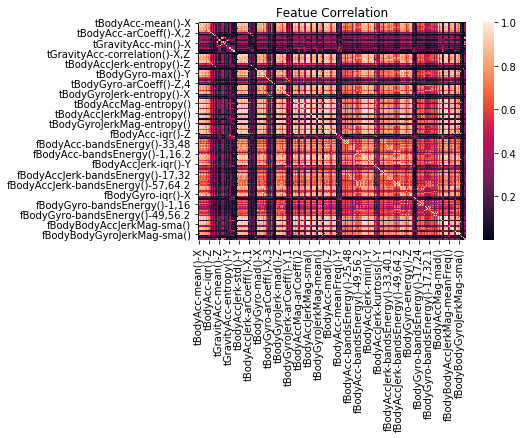

In [26]:
sns.heatmap(abs(Xcorr))
plt.title('Featue Correlation')
plt.show()

In [27]:
highcorr = pd.DataFrame()
# find high correlation features
corr_feat1 = []
corr_feat2 = []
for i in range(561):
    for x in range (561):
        if x > i:
            if Xcorr.iloc[i,x]>=.8:
                corr_feat1.append(Xcorr.index[i]) 
                corr_feat2.append(Xcorr.columns[x])

highcorr['var1'] = corr_feat1
highcorr['var2'] = corr_feat2

In [28]:
print('There are ',highcorr.shape[0],' instances of highly correlated variables')
display(highcorr.head())

There are  20886  instances of highly correlated variables


,var1,var2
0,tBodyAcc-std()-X,tBodyAcc-std()-Y
1,tBodyAcc-std()-X,tBodyAcc-std()-Z
2,tBodyAcc-std()-X,tBodyAcc-mad()-X
3,tBodyAcc-std()-X,tBodyAcc-mad()-Y
4,tBodyAcc-std()-X,tBodyAcc-mad()-Z


In [29]:
# create set of duplicate removed features using RFC feature importance
del_var = []
for i in range(highcorr.shape[0]):
    a = str(highcorr['var1'][i])
    b = str(highcorr['var2'][i])
    a_i = float(importances.loc[importances['Names'] == a,'Imp'])
    b_i = float(importances.loc[importances['Names'] == b,'Imp'])
    if a_i > b_i:
        del_var.append(b)
    elif a_i < b_i:
        del_var.append(a)
        
Xtrain_cor = Xtrain.drop(del_var,1)
Xtest_cor = Xtest.drop(del_var,1)
display(Xtrain_cor.head())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,"tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,2",...,fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-skewness(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.853011,0.359910,-0.058526,-0.224848,0.264106,-0.095246,-0.465085,...,-1.000000,0.586156,-1.000000,-0.074323,-0.298676,-0.112754,0.030400,-0.464761,-0.018446,-0.058627
1,0.278419,-0.016411,-0.123520,-0.329549,0.284213,0.284595,-0.090963,0.294310,-0.281211,-0.022153,...,-0.948718,-0.336310,-1.000000,0.158075,-0.595051,0.053477,-0.007435,-0.732626,0.703511,-0.054317
2,0.279653,-0.019467,-0.113462,-0.086309,0.337202,-0.164739,-0.074507,0.342256,-0.332564,-0.136204,...,-0.794872,-0.535352,-0.555556,0.414503,-0.390748,-0.118559,0.177899,0.100699,0.808529,-0.049118
3,0.279174,-0.026201,-0.123283,0.074840,0.198204,-0.264307,-0.155320,0.323154,-0.170813,-0.306081,...,-1.000000,-0.230091,-0.936508,0.404573,-0.117290,-0.036788,-0.012892,0.640011,-0.485366,-0.047663
4,0.276629,-0.016570,-0.115362,-0.131208,0.191161,0.086904,-0.272505,0.434728,-0.315375,-0.269069,...,-0.897436,-0.510282,-0.936508,0.087753,-0.351471,0.123320,0.122542,0.693578,-0.615971,-0.043892


In [30]:
#trying both models with both sets of variables
rfc = ensemble.RandomForestClassifier()

rfc.fit(Xtrain_cor,Ytrain)

print('Accuracy of Random Forest with RFC Determined Features')
print('\nTraing Accuracy:')
print(round(rfc.score(Xtrain_cor,Ytrain),4))
print('\nTesting Accuracy:')
print(round(rfc.score(Xtest_cor,Ytest),4))

Accuracy of Random Forest with RFC Determined Features

Traing Accuracy:
0.9993

Testing Accuracy:
0.9019


## Selecting From Model

In [31]:
rfc = ensemble.RandomForestClassifier()

rfc = rfc.fit(Xtrain,Ytrain)
sel = SelectFromModel(rfc, prefit=True)
Xtrain_sel = sel.transform(Xtrain)
Xtest_sel = sel.transform(Xtest)
print('Number of Features:')
print(Xtest_sel.shape[1])

Number of Features:
84


## Keeping the Most Importance Features

This time, I will only keep the most important features 

In [32]:
# create set most important features, determined by RFC
del_var = []
for i in importances['Names'][importances['Imp']>4.6]:
    del_var.append(i)
        
Xtrain_imp = Xtrain[del_var]
Xtest_imp = Xtest[del_var]
display(Xtrain_imp.head())

,"fBodyAcc-bandsEnergy()-1,24.1","fBodyAcc-bandsEnergy()-1,8",fBodyGyro-mad()-X,tBodyAccJerkMag-mad(),tBodyGyro-entropy()-X,tBodyGyroJerk-std()-X,fBodyAccMag-meanFreq(),fBodyAccMag-std(),tGravityAccMag-arCoeff()1,fBodyAccJerk-maxInds-Z,...,fBodyAccJerk-max()-X,fBodyAccJerk-energy()-X,"tGravityAcc-arCoeff()-Y,1",tGravityAcc-mean()-Y,"angle(Y,gravityMean)",tBodyAcc-std()-X,tGravityAcc-energy()-X,tBodyAccJerk-iqr()-X,tGravityAcc-min()-X,tGravityAcc-mean()-X
0,-0.999687,-0.999963,-0.986531,-0.994500,0.082632,-0.992111,-0.088436,-0.956134,-0.173179,-1.00,...,-0.996737,-0.999935,-0.745449,-0.140840,0.179941,-0.995279,0.899469,-0.994364,0.977436,0.963396
1,-0.999444,-0.999996,-0.979361,-0.992716,0.007469,-0.989873,-0.044150,-0.975866,0.081569,-0.32,...,-0.997425,-0.999960,-0.196359,-0.141551,0.180289,-0.998245,0.907829,-0.993863,0.984520,0.966561
2,-0.999126,-0.999989,-0.975609,-0.990650,-0.260943,-0.988462,0.257899,-0.989015,0.038049,-0.28,...,-0.995163,-0.999894,-0.329023,-0.142010,0.180637,-0.995380,0.908668,-0.987846,0.986770,0.966878
3,-0.999692,-0.999989,-0.989671,-0.993195,-0.930551,-0.991119,0.073581,-0.986742,-0.092856,-0.28,...,-0.993402,-0.999924,-0.295036,-0.143976,0.181935,-0.996091,0.910621,-0.994678,0.986821,0.967615
4,-0.999621,-0.999994,-0.982581,-0.996107,-0.628861,-0.991354,0.394310,-0.990063,0.180441,0.04,...,-0.997009,-0.999969,-0.166693,-0.148750,0.185151,-0.998139,0.912235,-0.995888,0.987434,0.968224


# Running Models

Now that I have reduced the number of features, I will run my models to predcit the outcome.

Since I have multiple different feature reduced sets, I will run my model multiple times with the multiple different feature selected training and testing sets.

In [33]:
# initiate dataframe to hold model test scores
scores = pd.DataFrame()
scores['Type'] = ['Training Score',
                  'Testing Score',
                  'Runtime (seconds)',
                  'Number of Features']

## Modeling Questions

1. Which set of features will work best at modeling the outcome? Will different sets work better with the 2 different models?
2. Which Model Works Best at Predicting the Data? 

## Random Forest

I will run the random forest model using both the features determined by random forest and the features determined by extra trees.  I will then compare how well each model did and show the feature importances of each set of features according to the random forest classifier.

### All Features

In [34]:
# testing all features
rfc_all = ensemble.RandomForestClassifier(random_state=3)

start = time.time()

rfc_all.fit(Xtrain,Ytrain)

cvscorerfc_all = cross_val_score(rfc_all,Xtrain,Ytrain,cv=5)

print('All Features:')
print('\nNumber of Features Used:')
print(Xtrain.shape[1])
print('\nTraining Accuracy Score:')
print(round(rfc_all.score(Xtrain,Ytrain),4))
print('\nTesting Accuracy Score:')
print(round(rfc_all.score(Xtest,Ytest),4))
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscorerfc_all.mean(),2),round(cvscorerfc_all.std()*2,2)))

end = time.time()
runtime_all = end - start

print('\nRuntime: ',round(runtime_all,2),' seconds')

All Features:

Number of Features Used:
561

Training Accuracy Score:
0.9996

Testing Accuracy Score:
0.8999

Cross Validation Score:
0.9% +/- 0.02%

Runtime:  6.76  seconds


In [35]:
vars_all = [ rfc_all.score(Xtrain,Ytrain),
             rfc_all.score(Xtest,Ytest),
             runtime_all,
             Xtrain.shape[1]
           ]
scores['All'] = vars_all

### Highly Correalted Features Removed

In [36]:
# testing features determined by removing highly correated features
rfc_cor = ensemble.RandomForestClassifier(random_state=3)

start = time.time()

rfc_cor.fit(Xtrain_cor,Ytrain)

cvscorerfc_cor = cross_val_score(rfc_cor,Xtrain_cor,Ytrain,cv=5)

print('All Features:')
print('\nNumber of Features Used:')
print(Xtrain_cor.shape[1])
print('\nTraining Accuracy Score:')
print(round(rfc_cor.score(Xtrain_cor,Ytrain),4))
print('\nTesting Accuracy Score:')
print(round(rfc_cor.score(Xtest_cor,Ytest),4))
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscorerfc_cor.mean(),2),round(cvscorerfc_cor.std()*2,2)))

end = time.time()
runtime_cor = end - start

print('\nRuntime: ',round(runtime_cor,2),' seconds')

All Features:

Number of Features Used:
176

Training Accuracy Score:
0.9993

Testing Accuracy Score:
0.9074

Cross Validation Score:
0.89% +/- 0.05%

Runtime:  4.1  seconds


In [37]:
vars_cor = [ rfc_cor.score(Xtrain_cor,Ytrain),
             rfc_cor.score(Xtest_cor,Ytest),
             runtime_cor,
             Xtrain_cor.shape[1]
           ]
scores['Correlation'] = vars_cor

### Selecting Features from the Model

In [38]:
# testing features determined by removing highly correated features
rfc_sel = ensemble.RandomForestClassifier(random_state=3)

start = time.time()

rfc_sel.fit(Xtrain_sel,Ytrain)

cvscorerfc_sel = cross_val_score(rfc_sel,Xtrain_sel,Ytrain,cv=5)

print('All Features:')
print('\nNumber of Features Used:')
print(Xtrain_sel.shape[1])
print('\nTraining Accuracy Score:')
print(round(rfc_sel.score(Xtrain_sel,Ytrain),4))
print('\nTesting Accuracy Score:')
print(round(rfc_sel.score(Xtest_sel,Ytest),4))
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscorerfc_sel.mean(),2),round(cvscorerfc_sel.std()*2,2)))

end = time.time()
runtime_sel = end - start

print('\nRuntime: ',round(runtime_sel,2),' seconds')

All Features:

Number of Features Used:
84

Training Accuracy Score:
0.9996

Testing Accuracy Score:
0.8792

Cross Validation Score:
0.89% +/- 0.05%

Runtime:  2.59  seconds


In [39]:
vars_sel = [ rfc_sel.score(Xtrain_sel,Ytrain),
             rfc_sel.score(Xtest_sel,Ytest),
             runtime_sel,
             Xtrain_sel.shape[1]
           ]
scores['Selection'] = vars_sel

### Highest Feature Importance

In [40]:
# testing features determined by removing highly correated features
rfc_imp = ensemble.RandomForestClassifier(random_state=3)

start = time.time()

rfc_imp.fit(Xtrain_imp,Ytrain)

cvscorerfc_imp = cross_val_score(rfc_imp,Xtrain_imp,Ytrain,cv=5)

print('All Features:')
print('\nNumber of Features Used:')
print(Xtrain_imp.shape[1])
print('\nTraining Accuracy Score:')
print(round(rfc_imp.score(Xtrain_imp,Ytrain),4))
print('\nTesting Accuracy Score:')
print(round(rfc_imp.score(Xtest_imp,Ytest),4))
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscorerfc_imp.mean(),2),round(cvscorerfc_imp.std()*2,2)))

end = time.time()
runtime_imp = end - start

print('\nRuntime: ',round(runtime_imp,2),' seconds')

All Features:

Number of Features Used:
66

Training Accuracy Score:
0.9989

Testing Accuracy Score:
0.8802

Cross Validation Score:
0.9% +/- 0.04%

Runtime:  2.21  seconds


In [41]:
vars_imp = [ rfc_imp.score(Xtrain_imp,Ytrain),
             rfc_imp.score(Xtest_imp,Ytest),
             runtime_imp,
            Xtrain_imp.shape[1]
           ]
scores['Importance'] = vars_imp

## Other Models

For consistency sake, I will model the other model types with only one feature set, the correlation feature set. I chose this one becuase it had the highest testing accuracy in the random forest model while also striking the best balance between reduced dimensionality and conserved variance.

### Extra Trees Classifier

In [42]:
# testing features determined by removing highly correated features
etc = ensemble.ExtraTreesClassifier(random_state=3)

start = time.time()

etc.fit(Xtrain_cor,Ytrain)

cvscoreetc = cross_val_score(etc,Xtrain_cor,Ytrain,cv=5)

print('All Features:')
print('\nTraining Accuracy Score:')
print(round(etc.score(Xtrain_cor,Ytrain),4))
print('\nTesting Accuracy Score:')
print(round(etc.score(Xtest_cor,Ytest),4))
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscoreetc.mean(),2),round(cvscoreetc.std()*2,2)))

end = time.time()
runtime_etc = end - start

print('\nRuntime: ',round(runtime_etc,2),' seconds')

All Features:

Training Accuracy Score:
1.0

Testing Accuracy Score:
0.8799

Cross Validation Score:
0.87% +/- 0.05%

Runtime:  1.13  seconds


In [43]:
vars_etc = [ etc.score(Xtrain_cor,Ytrain),
             etc.score(Xtest_cor,Ytest),
             runtime_etc,
             Xtrain_cor.shape[1]
           ]
scores['Xtra'] = vars_etc

### K Nearest Neighbors

In [44]:
# testing features determined by removing highly correated features
knn = neighbors.KNeighborsClassifier()

start = time.time()

knn.fit(Xtrain_cor,Ytrain)

cvscoreknn = cross_val_score(knn,Xtrain_cor,Ytrain,cv=5)

print('All Features:')
print('\nTraining Accuracy Score:')
print(round(knn.score(Xtrain_cor,Ytrain),4))
print('\nTesting Accuracy Score:')
print(round(knn.score(Xtest_cor,Ytest),4))
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscoreknn.mean(),2),round(cvscoreknn.std()*2,2)))

end = time.time()
runtime_knn = end - start

print('\nRuntime: ',round(runtime_knn,2),' seconds')

All Features:

Training Accuracy Score:
0.9784

Testing Accuracy Score:
0.8571

Cross Validation Score:
0.87% +/- 0.06%

Runtime:  54.11  seconds


In [45]:
vars_knn = [ knn.score(Xtrain_cor,Ytrain),
             knn.score(Xtest_cor,Ytest),
             runtime_knn,
             Xtrain_cor.shape[1]
           ]
scores['KNN'] = vars_knn

### Support Vector Classifier

In [46]:
# testing features determined by removing highly correated features
svc = SVC(random_state=3)

start = time.time()

svc.fit(Xtrain_cor,Ytrain)

cvscoresvc = cross_val_score(svc,Xtrain_cor,Ytrain,cv=5)

print('All Features:')
print('\nTraining Accuracy Score:')
print(round(svc.score(Xtrain_cor,Ytrain),4))
print('\nTesting Accuracy Score:')
print(round(svc.score(Xtest_cor,Ytest),4))
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscoresvc.mean(),2),round(cvscoresvc.std()*2,2)))

end = time.time()
runtime_svc = end - start

print('\nRuntime: ',round(runtime_svc,2),' seconds')

All Features:

Training Accuracy Score:
0.9604

Testing Accuracy Score:
0.9311

Cross Validation Score:
0.91% +/- 0.06%

Runtime:  32.13  seconds


In [47]:
vars_svc = [ svc.score(Xtrain_cor,Ytrain),
             svc.score(Xtest_cor,Ytest),
             runtime_svc,
             Xtrain_cor.shape[1]
           ]
scores['SVC'] = vars_svc

### Lasso Logistic Regression

In [48]:
# testing features determined by removing highly correated features
lrl = linear_model.LogisticRegression(penalty='l1',random_state=3)

start = time.time()

lrl.fit(Xtrain_cor,Ytrain)

cvscorelrl = cross_val_score(lrl,Xtrain_cor,Ytrain,cv=5)

print('All Features:')
print('\nTraining Accuracy Score:')
print(round(lrl.score(Xtrain_cor,Ytrain),4))
print('\nTesting Accuracy Score:')
print(round(lrl.score(Xtest_cor,Ytest),4))
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscorelrl.mean(),2),round(cvscorelrl.std()*2,2)))

end = time.time()
runtime_lrl = end - start

print('\nRuntime: ',round(runtime_lrl,2),' seconds')

All Features:

Training Accuracy Score:
0.9838

Testing Accuracy Score:
0.9386

Cross Validation Score:
0.93% +/- 0.06%

Runtime:  40.69  seconds


In [49]:
vars_etc = [ etc.score(Xtrain_cor,Ytrain),
             etc.score(Xtest_cor,Ytest),
             runtime_etc,
             Xtrain_cor.shape[1]
           ]
scores['Logistic'] = vars_etc

# Conclusion

How did my feature sets and models perform?

In [50]:
display(scores)

,Type,All,Correlation,Selection,Importance,Xtra,KNN,SVC,Logistic
0,Training Score,0.999592,0.999320,0.999592,0.998912,1.000000,0.978373,0.960419,1.000000
1,Testing Score,0.899898,0.907363,0.879199,0.880217,0.879878,0.857143,0.931116,0.879878
2,Runtime (seconds),6.761886,4.097019,2.594036,2.206104,1.127944,54.111315,32.134930,1.127944
3,Number of Features,561.000000,176.000000,84.000000,66.000000,176.000000,176.000000,176.000000,176.000000


This table has the results from both the different feature sets which trained the Random Forest Classifier and the additional models that were tested out.  The type column simple states what type of value is being looks at. The All, Correlation, Selection, and Importance column are the RFC models trained with the respective column name's feature set. Finally, the Xtra, KNN, SVC, and Logstic columns correspond with the Extra Trees Classifier, K Nearest Neighbors, Support Vector Classification, and Lasso Logistic Regression respectively. 

In order to better digest the results, I will look at my findings in 2 different sets, the RFC set (with different feature sets) and the Classification set (with different predictive models)

## RFC with Different Feature Sets

In [51]:
scores_rfc = scores.iloc[:,0:5]

In [52]:
scores_rfc.iloc[2,1:] = scores_rfc.iloc[2,1:] / scores_rfc.iloc[2,1:].max()
scores_rfc.iloc[3,1:] = scores_rfc.iloc[3,1:] / scores_rfc.iloc[3,1:].max()

display(scores_rfc)

,Type,All,Correlation,Selection,Importance
0,Training Score,0.999592,0.999320,0.999592,0.998912
1,Testing Score,0.899898,0.907363,0.879199,0.880217
2,Runtime (seconds),1.000000,0.605899,0.383626,0.326256
3,Number of Features,1.000000,0.313725,0.149733,0.117647


In [53]:
scores_rfc_plot = pd.melt(scores_rfc, id_vars='Type', var_name='Feature Determination', value_name='Value')

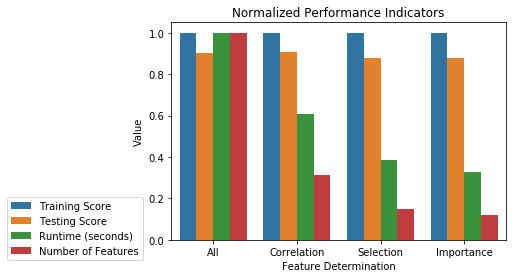

In [54]:
g = sns.barplot(x='Feature Determination', y='Value', data=scores_rfc_plot, hue='Type')
plt.title('Normalized Performance Indicators')
g.legend(loc=1, bbox_to_anchor=(-0.07, .22))
plt.show()

How did changing the features set affect modeling?

Reducing the number of features drastically reduced overall runtime and thus increased efficiency. However, it also reduced training and testing accuracy. The one exception to this is the correlation feature set, which actually has the best testing accuracy, having noticeably better accuracy than the entire feature set, though it followed the trend with training accuracy. 

## Predicting with Different Models

In [55]:
scores_other = scores[['Type','Correlation','Xtra','KNN','SVC','Logistic']]
scores_other.columns = ['Type','RFC','Xtra','KNN','SVC','Logistic']

In [56]:
scores_other = scores_other.iloc[:3,:]

In [57]:
display(scores_other)

,Type,RFC,Xtra,KNN,SVC,Logistic
0,Training Score,0.999320,1.000000,0.978373,0.960419,1.000000
1,Testing Score,0.907363,0.879878,0.857143,0.931116,0.879878
2,Runtime (seconds),4.097019,1.127944,54.111315,32.134930,1.127944


In [58]:
scores_other = scores_other.iloc[:3,:]
scores_other.iloc[2,1:] = scores_other.iloc[2,1:] / scores_other.iloc[2,1:].max()

display(scores_other)

,Type,RFC,Xtra,KNN,SVC,Logistic
0,Training Score,0.999320,1.000000,0.978373,0.960419,1.000000
1,Testing Score,0.907363,0.879878,0.857143,0.931116,0.879878
2,Runtime (seconds),0.075715,0.020845,1.000000,0.593867,0.020845


In [59]:
scores_other_plot = pd.melt(scores_other, id_vars='Type', var_name='Model Type', value_name='Value')

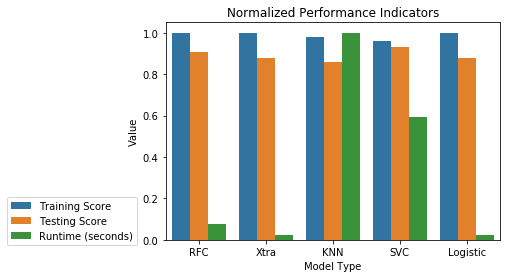

In [60]:
g = sns.barplot(x='Model Type', y='Value', data=scores_other_plot, hue='Type')
plt.title('Normalized Performance Indicators')
g.legend(loc=1, bbox_to_anchor=(-0.07, .22))
plt.show()

The Support Vector Classifier put out the best testing score, but also had a pretty high runtime. If accuracy was much more important that efficiency, I would use SVC.

The Random Forest Classifier put out the second best testing score and a very reasonable runtime. If accuracy and efficiency were equally as important, I would choose RFC.

Though having slightly different results, the Extra Trees Classifier and Lasso Logistic Regression compare similarly to the RFC results.  Both were slighly less accurate in their testing score than RFC, but both were also slightly more efficient. However, there marginal increase in efficiency would probably not be worth the decrease in accuracy.

K Nearest Neighbors appears to be completely unsuited to model this data set, having the longest runtime and the lowest testing score.

RFC appears to generally be the best model to use, having the most reasonable intersection of performance accuracy and efficiency. However, if I had high amounts of processing power and I needed the best results, I would use SVC

# References

https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones